In [2]:
!pip install pennylane torch numpy matplotlib

In [5]:
import pennylane as qml
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("🔬 Quantum Recurrent Neural Network Implementation")
print("=" * 50)

# Check available quantum devices - CORRECTED VERSION
dev = qml.device("default.qubit", wires=4)
print(f"✅ Quantum device: {dev.name}")

# CORRECT way to get number of wires in PennyLane
print(f"✅ Number of wires: {len(dev.wires)}")
print(f"✅ Device wires: {dev.wires}")

# Let's also test if the device works with a simple circuit
@qml.qnode(dev)
def simple_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

print(f"✅ Simple circuit test: {simple_circuit():.4f}")
print("✅ Environment setup completed successfully!")

🔬 Quantum Recurrent Neural Network Implementation
✅ Quantum device: default.qubit
✅ Number of wires: 4
✅ Device wires: Wires([0, 1, 2, 3])
✅ Simple circuit test: 0.0000
✅ Environment setup completed successfully!



🧪 Testing Fixed QRNN Cell...
🔗 Quantum Circuit Diagram:


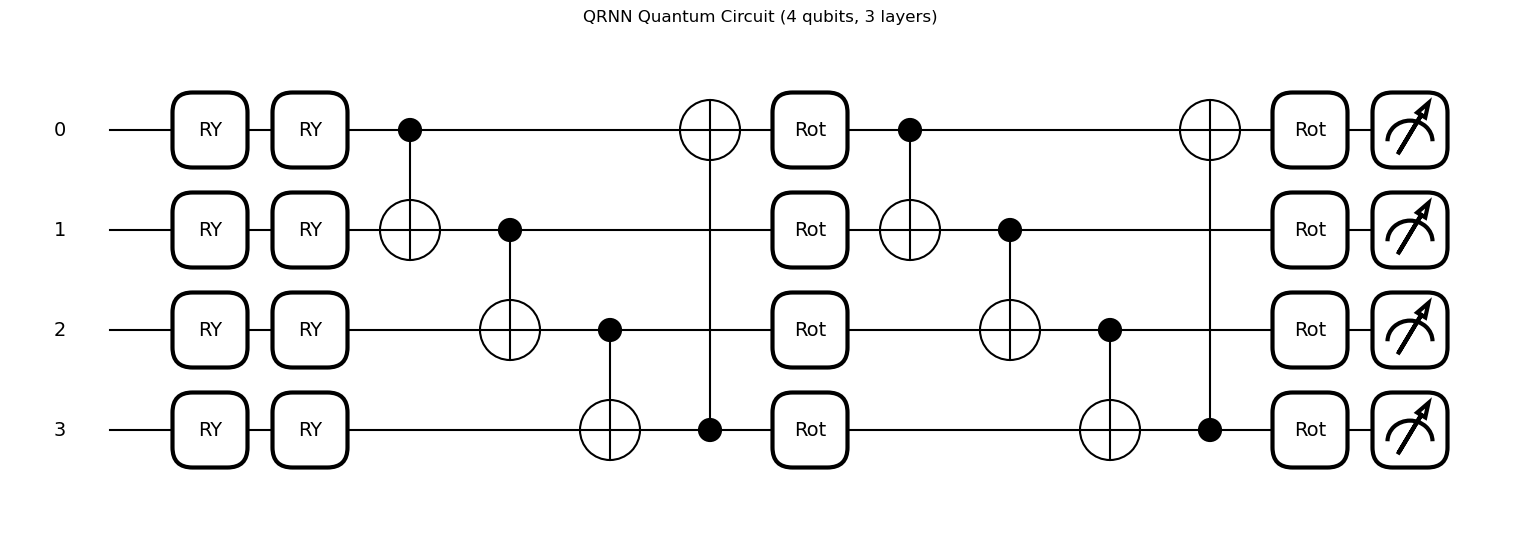

✅ Input shape: torch.Size([3]), dtype: torch.float32
✅ Hidden state shape: torch.Size([5]) → torch.Size([5]), dtype: torch.float32
✅ Forward pass successful!

🧪 Testing Batch Processing...
✅ Batch input shape: torch.Size([2, 3])
✅ Batch hidden state shape: torch.Size([2, 5]) → torch.Size([2, 5])


In [8]:
import torch
import torch.nn as nn
import pennylane as qml
import matplotlib.pyplot as plt

# Make sure you have a device defined (add this at the top)
dev = qml.device("default.qubit", wires=4)  # Adjust wires as needed

class QRNNCell(nn.Module):
    """
    Quantum Recurrent Neural Network Cell
    Hybrid quantum-classical architecture
    """
    def __init__(self, input_dim, hidden_dim, n_qubits, n_quantum_layers):
        super(QRNNCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits
        self.n_quantum_layers = n_quantum_layers
        
        # Classical neural networks for encoding/decoding
        self.input_encoder = nn.Linear(input_dim, n_qubits)
        self.hidden_encoder = nn.Linear(hidden_dim, n_qubits)
        self.output_decoder = nn.Linear(n_qubits, hidden_dim)
        
        # Quantum circuit parameters - initialize with proper dtype
        self.q_params = nn.Parameter(torch.randn(n_quantum_layers, n_qubits, 3))
        
    def quantum_circuit(self, inputs, hidden_state):
        """
        Parameterized quantum circuit for recurrent processing
        """
        @qml.qnode(dev, interface="torch")
        def circuit(input_enc, hidden_enc, params):
            # Encode classical data into quantum states
            for i in range(self.n_qubits):
                # Use modulo to handle cases where input dimension doesn't match qubit count
                input_val = input_enc[i % len(input_enc)] if len(input_enc) > 0 else 0.0
                hidden_val = hidden_enc[i % len(hidden_enc)] if len(hidden_enc) > 0 else 0.0
                
                qml.RY(input_val, wires=i)
                qml.RY(hidden_val, wires=i)
            
            # Parametrized quantum layers
            for layer in range(self.n_quantum_layers):
                # Entangling layer
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                if self.n_qubits > 1:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
                
                # Parametrized rotations
                for qubit in range(self.n_qubits):
                    qml.Rot(*params[layer, qubit], wires=qubit)
            
            # Measure expectations
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        return circuit(inputs, hidden_state, self.q_params)
    
    def forward(self, x, h_prev):
        # Ensure input tensors are float32 to match network weights
        x = x.float()
        h_prev = h_prev.float()
        
        # Encode inputs to quantum compatible format
        input_enc = torch.tanh(self.input_encoder(x)).squeeze()
        hidden_enc = torch.tanh(self.hidden_encoder(h_prev)).squeeze()
        
        # Ensure the encoded tensors are 1D
        if input_enc.dim() > 1:
            input_enc = input_enc.view(-1)
        if hidden_enc.dim() > 1:
            hidden_enc = hidden_enc.view(-1)
        
        # Quantum processing
        quantum_output = self.quantum_circuit(input_enc, hidden_enc)
        quantum_output = torch.stack(quantum_output) if isinstance(quantum_output, (list, tuple)) else quantum_output
        
        # Ensure quantum output has correct shape and convert to float32
        if quantum_output.dim() == 0:  # scalar
            quantum_output = quantum_output.unsqueeze(0)
        
        # Convert quantum output to float32 to match linear layer weights
        quantum_output = quantum_output.float()
        
        # Decode quantum output to classical hidden state
        h_next = torch.tanh(self.output_decoder(quantum_output))
        
        return h_next
    
    def draw_circuit(self):
        """Visualize the quantum circuit"""
        print("🔗 Quantum Circuit Diagram:")
        print("=" * 40)
        
        # Create a dummy circuit for visualization with proper encoding
        @qml.qnode(dev)
        def dummy_circuit():
            # Example encoding with proper dimension handling
            input_enc = [0.5] * min(4, self.n_qubits)
            hidden_enc = [0.3] * min(4, self.n_qubits)
            
            for i in range(self.n_qubits):
                input_val = input_enc[i % len(input_enc)] if i < len(input_enc) else 0.0
                hidden_val = hidden_enc[i % len(hidden_enc)] if i < len(hidden_enc) else 0.0
                qml.RY(input_val, wires=i)
                qml.RY(hidden_val, wires=i)
            
            # Example layers
            for layer in range(min(2, self.n_quantum_layers)):
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                if self.n_qubits > 1:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
                for qubit in range(self.n_qubits):
                    qml.Rot(0.1, 0.2, 0.3, wires=qubit)
            
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        try:
            fig, ax = qml.draw_mpl(dummy_circuit)()
            plt.title(f"QRNN Quantum Circuit ({self.n_qubits} qubits, {self.n_quantum_layers} layers)")
            plt.show()
        except Exception as e:
            print(f"⚠️ Circuit visualization failed: {e}")
            print("📋 Text-based circuit representation:")
            print(qml.draw(dummy_circuit)())

# Test the fixed QRNN Cell
print("\n🧪 Testing Fixed QRNN Cell...")
qrnn_cell = QRNNCell(input_dim=3, hidden_dim=5, n_qubits=4, n_quantum_layers=3)

# Visualize the circuit
qrnn_cell.draw_circuit()

# Test forward pass with proper tensor shapes and dtype
x = torch.randn(3)  # Input vector of shape (3,)
h_prev = torch.zeros(5)  # Hidden state of shape (5,)
h_next = qrnn_cell(x, h_prev)

print(f"✅ Input shape: {x.shape}, dtype: {x.dtype}")
print(f"✅ Hidden state shape: {h_prev.shape} → {h_next.shape}, dtype: {h_next.dtype}")
print(f"✅ Forward pass successful!")

# Test with batch processing
print("\n🧪 Testing Batch Processing...")
x_batch = torch.randn(2, 3)  # Batch of 2 samples, each with 3 features
h_prev_batch = torch.zeros(2, 5)  # Batch of hidden states

# Process each sample in the batch
h_next_batch = []
for i in range(x_batch.shape[0]):
    h_next = qrnn_cell(x_batch[i], h_prev_batch[i])
    h_next_batch.append(h_next)

h_next_batch = torch.stack(h_next_batch)
print(f"✅ Batch input shape: {x_batch.shape}")
print(f"✅ Batch hidden state shape: {h_prev_batch.shape} → {h_next_batch.shape}")


📊 Generating Time Series Dataset...


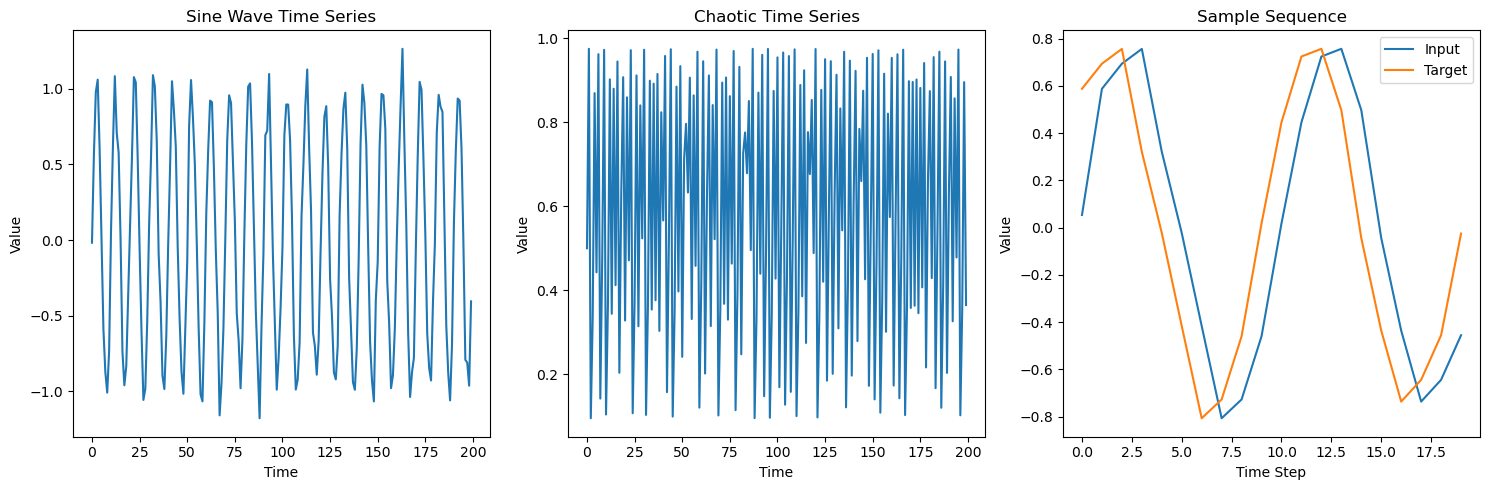

✅ Training data shape: torch.Size([7984, 20, 1])
✅ Testing data shape: torch.Size([1996, 20, 1])


In [9]:
class TimeSeriesDataset:
    """Generate synthetic time series data for testing"""
    
    def __init__(self, seq_length=50, n_sequences=1000):
        self.seq_length = seq_length
        self.n_sequences = n_sequences
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        
    def generate_sine_wave(self, frequency=0.1, noise_level=0.1):
        """Generate sine wave with noise"""
        time = np.arange(self.n_sequences * self.seq_length)
        signal = np.sin(2 * np.pi * frequency * time)
        noise = np.random.normal(0, noise_level, len(time))
        return signal + noise
    
    def generate_chaotic_data(self):
        """Generate chaotic time series (Logistic map)"""
        data = [0.5]
        for _ in range(self.n_sequences * self.seq_length - 1):
            data.append(3.9 * data[-1] * (1 - data[-1]))
        return np.array(data)
    
    def prepare_data(self, data_type="sine"):
        """Prepare training and testing data"""
        if data_type == "sine":
            data = self.generate_sine_wave()
        else:
            data = self.generate_chaotic_data()
        
        # Normalize data
        data = self.scaler.fit_transform(data.reshape(-1, 1)).flatten()
        
        # Create sequences
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            X.append(data[i:i + self.seq_length])
            y.append(data[i + 1:i + self.seq_length + 1])
        
        X = np.array(X)
        y = np.array(y)
        
        # Split into train/test
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        return (torch.FloatTensor(X_train).unsqueeze(-1), 
                torch.FloatTensor(y_train).unsqueeze(-1),
                torch.FloatTensor(X_test).unsqueeze(-1),
                torch.FloatTensor(y_test).unsqueeze(-1))

# Generate and visualize dataset
print("\n📊 Generating Time Series Dataset...")
dataset = TimeSeriesDataset(seq_length=20, n_sequences=500)
X_train, y_train, X_test, y_test = dataset.prepare_data("sine")

# Visualize the data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(dataset.generate_sine_wave()[:200])
plt.title("Sine Wave Time Series")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(1, 3, 2)
plt.plot(dataset.generate_chaotic_data()[:200])
plt.title("Chaotic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(1, 3, 3)
plt.plot(X_train[0].numpy(), label='Input')
plt.plot(y_train[0].numpy(), label='Target')
plt.title("Sample Sequence")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

print(f"✅ Training data shape: {X_train.shape}")
print(f"✅ Testing data shape: {X_test.shape}")

In [14]:
class QRNN(nn.Module):
    """
    Complete Quantum RNN model for sequence processing
    """
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_quantum_layers, n_layers=1):
        super(QRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # QRNN cells - first layer takes input_dim, subsequent layers take hidden_dim
        self.qrnn_cells = nn.ModuleList()
        self.qrnn_cells.append(QRNNCell(input_dim, hidden_dim, n_qubits, n_quantum_layers))
        
        # Additional layers if needed
        for _ in range(n_layers - 1):
            self.qrnn_cells.append(QRNNCell(hidden_dim, hidden_dim, n_qubits, n_quantum_layers))
        
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h0=None):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, input_dim = x.shape
        
        # Initialize hidden state
        if h0 is None:
            # Initialize with correct shape: (n_layers, batch_size, hidden_dim)
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
        # Ensure h0 has the right shape and dtype
        h0 = h0.float()
        
        # Store outputs for each time step
        outputs = []
        
        # Initialize hidden states for each layer
        # Split h0 into list of tensors for each layer
        hidden_states = [h0[i] for i in range(self.n_layers)]  # Each is (batch_size, hidden_dim)
        
        # Process through time steps
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_dim)
            
            # Process through layers
            new_hidden_states = []
            for layer_idx in range(self.n_layers):
                if layer_idx == 0:
                    # First layer uses input
                    h_new = self.qrnn_cells[layer_idx](x_t, hidden_states[layer_idx])
                else:
                    # Subsequent layers use previous layer's hidden state
                    h_new = self.qrnn_cells[layer_idx](new_hidden_states[layer_idx-1], hidden_states[layer_idx])
                
                new_hidden_states.append(h_new)
            
            # Update hidden states for next time step
            hidden_states = new_hidden_states
            
            # Store output from the last layer (batch_size, hidden_dim)
            outputs.append(hidden_states[-1])
        
        # Stack outputs along sequence dimension
        # outputs is a list of tensors, each of shape (batch_size, hidden_dim)
        # After stacking: (batch_size, seq_len, hidden_dim)
        if len(outputs) > 0:
            outputs = torch.stack(outputs, dim=1)
            
            # Apply output layer to each time step
            batch_size, seq_len, hidden_dim = outputs.shape
            outputs_reshaped = outputs.reshape(batch_size * seq_len, hidden_dim)
            output_reshaped = self.fc(outputs_reshaped)
            output = output_reshaped.reshape(batch_size, seq_len, -1)
        else:
            # Handle empty sequence case
            output = torch.zeros(batch_size, 0, self.fc.out_features)
        
        # Final hidden state (for all layers)
        final_hidden = torch.stack(hidden_states, dim=0)  # (n_layers, batch_size, hidden_dim)
        
        return output, final_hidden

# Let's also fix the QRNNCell to properly handle batch processing
class QRNNCell(nn.Module):
    """
    Quantum Recurrent Neural Network Cell (Batch-compatible version)
    """
    def __init__(self, input_dim, hidden_dim, n_qubits, n_quantum_layers):
        super(QRNNCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits
        self.n_quantum_layers = n_quantum_layers
        
        # Classical neural networks for encoding/decoding
        self.input_encoder = nn.Linear(input_dim, n_qubits)
        self.hidden_encoder = nn.Linear(hidden_dim, n_qubits)
        self.output_decoder = nn.Linear(n_qubits, hidden_dim)
        
        # Quantum circuit parameters
        self.q_params = nn.Parameter(torch.randn(n_quantum_layers, n_qubits, 3))
        
    def quantum_circuit(self, inputs, hidden_state):
        """
        Parameterized quantum circuit for recurrent processing
        """
        @qml.qnode(dev, interface="torch")
        def circuit(input_enc, hidden_enc, params):
            # Encode classical data into quantum states
            for i in range(self.n_qubits):
                input_val = input_enc[i % len(input_enc)] if len(input_enc) > 0 else 0.0
                hidden_val = hidden_enc[i % len(hidden_enc)] if len(hidden_enc) > 0 else 0.0
                
                qml.RY(input_val, wires=i)
                qml.RY(hidden_val, wires=i)
            
            # Parametrized quantum layers
            for layer in range(self.n_quantum_layers):
                # Entangling layer
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                if self.n_qubits > 1:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
                
                # Parametrized rotations
                for qubit in range(self.n_qubits):
                    qml.Rot(*params[layer, qubit], wires=qubit)
            
            # Measure expectations
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        return circuit(inputs, hidden_state, self.q_params)
    
    def forward(self, x, h_prev):
        # Handle batch and single sample cases
        if x.dim() == 1:
            # Single sample: (input_dim,) -> add batch dimension
            x = x.unsqueeze(0)
            h_prev = h_prev.unsqueeze(0)
            single_sample = True
        else:
            single_sample = False
            
        batch_size = x.size(0)
        
        # Ensure correct dtype
        x = x.float()
        h_prev = h_prev.float()
        
        # Process each sample in the batch
        h_next_batch = []
        for i in range(batch_size):
            x_i = x[i]  # (input_dim,)
            h_prev_i = h_prev[i]  # (hidden_dim,)
            
            # Encode inputs
            input_enc = torch.tanh(self.input_encoder(x_i)).squeeze()
            hidden_enc = torch.tanh(self.hidden_encoder(h_prev_i)).squeeze()
            
            # Ensure 1D tensors
            if input_enc.dim() > 1:
                input_enc = input_enc.view(-1)
            if hidden_enc.dim() > 1:
                hidden_enc = hidden_enc.view(-1)
            
            # Quantum processing
            quantum_output = self.quantum_circuit(input_enc, hidden_enc)
            quantum_output = torch.stack(quantum_output) if isinstance(quantum_output, (list, tuple)) else quantum_output
            
            # Ensure correct shape
            if quantum_output.dim() == 0:
                quantum_output = quantum_output.unsqueeze(0)
            
            # Convert to float32
            quantum_output = quantum_output.float()
            
            # Decode to hidden state
            h_next_i = torch.tanh(self.output_decoder(quantum_output))
            h_next_batch.append(h_next_i)
        
        # Stack results
        h_next = torch.stack(h_next_batch)
        
        # Remove batch dimension if it was a single sample
        if single_sample:
            h_next = h_next.squeeze(0)
            
        return h_next
    
    def draw_circuit(self):
        """Visualize the quantum circuit"""
        print("🔗 Quantum Circuit Diagram:")
        print("=" * 40)
        
        # Create a dummy circuit for visualization
        @qml.qnode(dev)
        def dummy_circuit():
            input_enc = [0.5] * min(4, self.n_qubits)
            hidden_enc = [0.3] * min(4, self.n_qubits)
            
            for i in range(self.n_qubits):
                input_val = input_enc[i % len(input_enc)] if i < len(input_enc) else 0.0
                hidden_val = hidden_enc[i % len(hidden_enc)] if i < len(hidden_enc) else 0.0
                qml.RY(input_val, wires=i)
                qml.RY(hidden_val, wires=i)
            
            for layer in range(min(2, self.n_quantum_layers)):
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                if self.n_qubits > 1:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
                for qubit in range(self.n_qubits):
                    qml.Rot(0.1, 0.2, 0.3, wires=qubit)
            
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        try:
            fig, ax = qml.draw_mpl(dummy_circuit)()
            plt.title(f"QRNN Quantum Circuit ({self.n_qubits} qubits, {self.n_quantum_layers} layers)")
            plt.show()
        except Exception as e:
            print(f"⚠️ Circuit visualization failed: {e}")
            print("📋 Text-based circuit representation:")
            print(qml.draw(dummy_circuit)())

# Test the complete QRNN model
print("\n🧠 Testing Complete QRNN Model...")
model = QRNN(input_dim=1, hidden_dim=8, output_dim=1, n_qubits=4, n_quantum_layers=3)

# Test forward pass
test_input = torch.randn(32, 20, 1)  # batch_size, seq_len, input_dim
output, hidden_state = model(test_input)

print(f"✅ Model input shape: {test_input.shape}")
print(f"✅ Model output shape: {output.shape}")
print(f"✅ Hidden state shape: {hidden_state.shape}")

# Display model architecture
print("\n🏗️ Model Architecture:")
print(model)

# Test with a single sample
print("\n🧪 Testing with Single Sample...")
single_input = torch.randn(1, 10, 1)  # batch_size=1, seq_len=10, input_dim=1
single_output, single_hidden = model(single_input)
print(f"✅ Single sample input shape: {single_input.shape}")
print(f"✅ Single sample output shape: {single_output.shape}")
print(f"✅ Single sample hidden state shape: {single_hidden.shape}")


🧠 Testing Complete QRNN Model...
✅ Model input shape: torch.Size([32, 20, 1])
✅ Model output shape: torch.Size([32, 20, 1])
✅ Hidden state shape: torch.Size([1, 32, 8])

🏗️ Model Architecture:
QRNN(
  (qrnn_cells): ModuleList(
    (0): QRNNCell(
      (input_encoder): Linear(in_features=1, out_features=4, bias=True)
      (hidden_encoder): Linear(in_features=8, out_features=4, bias=True)
      (output_decoder): Linear(in_features=4, out_features=8, bias=True)
    )
  )
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

🧪 Testing with Single Sample...
✅ Single sample input shape: torch.Size([1, 10, 1])
✅ Single sample output shape: torch.Size([1, 10, 1])
✅ Single sample hidden state shape: torch.Size([1, 1, 8])


🚀 Creating QRNN with Backprop Differentiation...
Data shapes - X_train: torch.Size([800, 20, 5]), y_train: torch.Size([800, 1])
Data types - X_train: torch.float32, y_train: torch.float32
Using simplified QRNN for debugging...
Model created with 129 parameters
Model dtype: torch.float32
=== Debugging Dtypes ===
Model parameters dtype: torch.float32
Data dtype: torch.float32
Target dtype: torch.float32

🏃 Starting Training with Backprop (Fast Mode)...

--- Epoch 1 ---
Epoch: 1 [0/800 (0%)]	Loss: 15.330811
Epoch: 1 [320/800 (40%)]	Loss: 8.710366
Epoch: 1 [640/800 (80%)]	Loss: 15.868402
Epoch 1 Complete: Train Loss: 14.689265, Test Loss: 14.356616

--- Epoch 2 ---
Epoch: 2 [0/800 (0%)]	Loss: 13.489115
Epoch: 2 [320/800 (40%)]	Loss: 14.574076
Epoch: 2 [640/800 (80%)]	Loss: 8.910298
Epoch 2 Complete: Train Loss: 11.914519, Test Loss: 11.783323

--- Epoch 3 ---
Epoch: 3 [0/800 (0%)]	Loss: 12.047374
Epoch: 3 [320/800 (40%)]	Loss: 8.575160
Epoch: 3 [640/800 (80%)]	Loss: 12.053886
Epoch 3 Compl

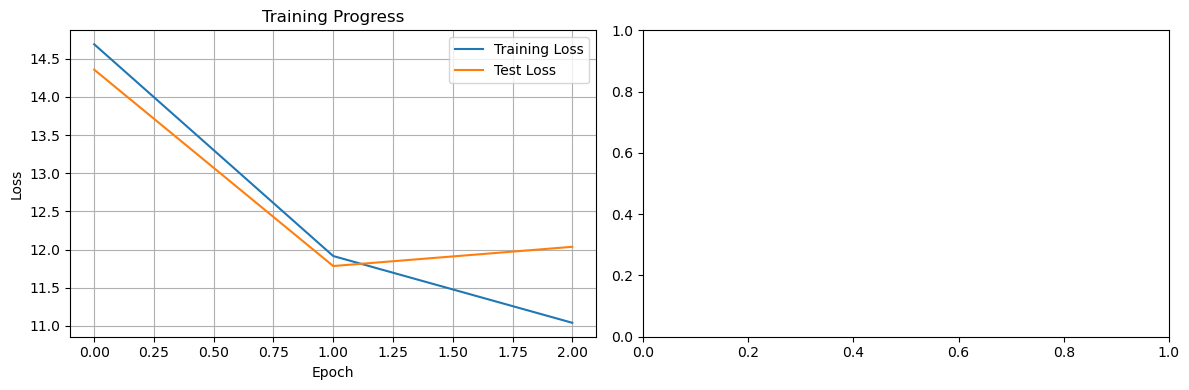


🧪 Testing predictions...
Sample target: 1.0324
Prediction: 2.6910
Absolute error: 1.6585

✅ Training completed successfully!

💡 If you still have issues, try the FixedQRNNCell class above


In [21]:
import pennylane as qml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Fix dtype issues completely
class QRNNCellWithBackprop(nn.Module):
    """Quantum RNN Cell with backprop differentiation for faster training"""
    
    def __init__(self, input_dim, hidden_dim, n_qubits=4, n_layers=2):
        super(QRNNCellWithBackprop, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_qubits = n_qubits
        
        # Device with backprop differentiation
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        # Classical neural network for input processing
        self.input_layer = nn.Linear(input_dim + hidden_dim, n_qubits)
        
        # Quantum parameters - ensure they're Float32
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits, 3, dtype=torch.float32))
        
        # Output layer
        self.output_layer = nn.Linear(n_qubits, hidden_dim)
        
        # Create the quantum circuit
        self.quantum_circuit = self.create_quantum_circuit()
        
    def create_quantum_circuit(self):
        """Create quantum circuit with backprop differentiation"""
        
        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(inputs, weights):
            # Quantum circuit implementation
            # Initialize qubits
            for i in range(self.n_qubits):
                qml.Hadamard(wires=i)
            
            # Encode classical data - ensure proper scaling
            for i in range(self.n_qubits):
                if i < len(inputs):
                    # Use tanh to ensure values are between -pi and pi
                    encoded_value = torch.tanh(inputs[i]) * np.pi
                    qml.RY(encoded_value, wires=i)
            
            # Variational layers
            for layer in range(weights.shape[0]):
                # Rotational gates
                for i in range(self.n_qubits):
                    qml.Rot(weights[layer, i, 0], weights[layer, i, 1], weights[layer, i, 2], wires=i)
                
                # Entangling gates
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                if self.n_qubits > 1:
                    qml.CNOT(wires=[self.n_qubits - 1, 0])
            
            # Return measurements for all qubits
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        return circuit
    
    def forward(self, x, hidden=None):
        # Ensure input is Float32
        x = x.to(torch.float32)
        
        batch_size = x.size(0)
        
        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, dtype=torch.float32, device=x.device)
        else:
            hidden = hidden.to(torch.float32)
        
        # Combine input and hidden state
        combined = torch.cat((x, hidden), dim=1)
        
        # Classical processing
        classical_out = torch.tanh(self.input_layer(combined))
        
        # Apply quantum circuit to each sample in batch
        quantum_outputs = []
        for i in range(batch_size):
            with torch.no_grad():
                # Ensure inputs are properly scaled for quantum circuit
                circuit_input = torch.tanh(classical_out[i])  # Scale to [-1, 1]
                q_out = self.quantum_circuit(circuit_input, self.q_params)
                quantum_outputs.append(torch.stack(q_out))
        
        quantum_output = torch.stack(quantum_outputs)
        
        # Ensure quantum output is float32 and properly shaped
        quantum_output = quantum_output.to(torch.float32)
        
        # Final output
        output = torch.tanh(self.output_layer(quantum_output))
        
        return output, output

class QRNNWithBackprop(nn.Module):
    """Complete QRNN model using backprop-enabled cells"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=4, n_layers=2, num_layers=1):
        super(QRNNWithBackprop, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Create QRNN cells
        self.qrnn_cells = nn.ModuleList([
            QRNNCellWithBackprop(input_dim if i == 0 else hidden_dim, 
                               hidden_dim, n_qubits, n_layers)
            for i in range(num_layers)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden=None):
        # Ensure input is Float32
        x = x.to(torch.float32)
        
        batch_size, seq_len, input_dim = x.size()
        
        if hidden is None:
            hidden = [None] * self.num_layers
        
        # Process each time step
        outputs = []
        current_hidden = list(hidden)
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            for layer_idx, cell in enumerate(self.qrnn_cells):
                x_t, new_hidden = cell(x_t, current_hidden[layer_idx])
                current_hidden[layer_idx] = new_hidden
            
            outputs.append(x_t)
        
        # Stack outputs and apply final layer
        output = torch.stack(outputs, dim=1)
        output = self.output_layer(output[:, -1, :])  # Use last time step for prediction
        
        return output, current_hidden

class QRNNTrainer:
    """Optimized Training and evaluation class for QRNN with backprop"""
    
    def __init__(self, model, learning_rate=0.01):
        # Ensure model is in float32
        self.model = model.float()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
        # Training history
        self.train_losses = []
        self.test_losses = []
        
    def train_epoch(self, train_loader, epoch):
        self.model.train()
        total_loss = 0
        num_batches = len(train_loader)
        
        for batch_idx, (data, target) in enumerate(train_loader):
            self.optimizer.zero_grad()
            
            # Ensure data and target are Float32 and on same device
            data = data.to(torch.float32).to(next(self.model.parameters()).device)
            target = target.to(torch.float32).to(next(self.model.parameters()).device)
            
            try:
                # Forward pass
                output, _ = self.model(data)
                loss = self.criterion(output, target)
                
                # Backward pass
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                
                # Less frequent logging to reduce overhead
                if batch_idx % 10 == 0:
                    print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                          f'({100. * batch_idx / num_batches:.0f}%)]\tLoss: {loss.item():.6f}')
                    
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                # Continue with next batch
                continue
        
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss
    
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                # Ensure data and target are Float32
                data = data.to(torch.float32).to(next(self.model.parameters()).device)
                target = target.to(torch.float32).to(next(self.model.parameters()).device)
                
                output, _ = self.model(data)
                total_loss += self.criterion(output, target).item()
        
        avg_loss = total_loss / len(test_loader)
        self.test_losses.append(avg_loss)
        return avg_loss
    
    def plot_training_progress(self):
        """Visualize training progress"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        # Plot quantum circuit parameters evolution
        if hasattr(self.model, 'qrnn_cells') and len(self.model.qrnn_cells) > 0:
            params = self.model.qrnn_cells[0].q_params.detach().cpu().numpy()
            plt.imshow(params.reshape(-1, params.shape[-1]), aspect='auto', cmap='viridis')
            plt.colorbar(label='Parameter Value')
            plt.title('Quantum Parameters Evolution')
            plt.xlabel('Parameter Dimension')
            plt.ylabel('Parameter Index')
        
        plt.tight_layout()
        plt.show()

# Create sample data with proper dtype
def create_sample_data(seq_length=20, num_samples=1000, input_dim=5, output_dim=1):
    """Create sample time series data for testing with proper dtype"""
    # Generate random time series data - ensure Float32
    X = torch.randn(num_samples, seq_length, input_dim, dtype=torch.float32)
    # Simple target: sum of last few time steps
    y = torch.sum(X[:, -3:, :], dim=(1, 2)).unsqueeze(1)
    
    # Split into train/test
    split_idx = int(0.8 * num_samples)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

# Debug function to check dtypes
def debug_dtypes(model, data_loader):
    """Debug function to check all dtypes"""
    print("=== Debugging Dtypes ===")
    print(f"Model parameters dtype: {next(model.parameters()).dtype}")
    
    sample_data, sample_target = next(iter(data_loader))
    print(f"Data dtype: {sample_data.dtype}")
    print(f"Target dtype: {sample_target.dtype}")
    
    # Check quantum circuit
    if hasattr(model, 'qrnn_cells') and len(model.qrnn_cells) > 0:
        cell = model.qrnn_cells[0]
        print(f"Quantum params dtype: {cell.q_params.dtype}")
        
        # Test quantum circuit
        test_input = torch.randn(1, cell.input_layer.in_features, dtype=torch.float32)
        classical_out = torch.tanh(cell.input_layer(test_input))
        
        try:
            q_out = cell.quantum_circuit(classical_out[0], cell.q_params)
            print(f"Quantum output dtype: {q_out[0].dtype if isinstance(q_out, list) else q_out.dtype}")
        except Exception as e:
            print(f"Quantum circuit test failed: {e}")
    
    print("========================")

# Simplified version for testing
class SimpleQRNN(nn.Module):
    """Simplified QRNN for debugging"""
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=4):
        super(SimpleQRNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Simple quantum-inspired layer (classical for now)
        self.quantum_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden=None):
        x = x.to(torch.float32)
        batch_size, seq_len, input_dim = x.size()
        
        # Use last time step only for simplicity
        x_last = x[:, -1, :]
        
        # Quantum-inspired processing
        hidden_state = self.quantum_layer(x_last)
        output = self.output_layer(hidden_state)
        
        return output, hidden_state

# Main execution
if __name__ == "__main__":
    print("🚀 Creating QRNN with Backprop Differentiation...")
    
    # Create sample data
    X_train, X_test, y_train, y_test = create_sample_data()
    print(f"Data shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Data types - X_train: {X_train.dtype}, y_train: {y_train.dtype}")
    
    # Try the simple version first for debugging
    use_simple = True  # Set to False to try the quantum version
    
    if use_simple:
        print("Using simplified QRNN for debugging...")
        model = SimpleQRNN(
            input_dim=X_train.shape[2], 
            hidden_dim=8, 
            output_dim=y_train.shape[1]
        )
    else:
        print("Using full quantum QRNN...")
        model = QRNNWithBackprop(
            input_dim=X_train.shape[2], 
            hidden_dim=8, 
            output_dim=y_train.shape[1],
            n_qubits=4,
            n_layers=2,
            num_layers=1
        )
    
    # Ensure model is in the right dtype
    model = model.float()
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Model dtype: {next(model.parameters()).dtype}")
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Debug dtypes
    debug_dtypes(model, train_loader)
    
    # Initialize trainer
    trainer = QRNNTrainer(model, learning_rate=0.01)
    
    print("\n🏃 Starting Training with Backprop (Fast Mode)...")
    
    # Train for a few epochs
    n_epochs = 3  # Start with fewer epochs for testing
    for epoch in range(1, n_epochs + 1):
        print(f"\n--- Epoch {epoch} ---")
        try:
            train_loss = trainer.train_epoch(train_loader, epoch)
            test_loss = trainer.evaluate(test_loader)
            print(f"Epoch {epoch} Complete: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        except Exception as e:
            print(f"Error in epoch {epoch}: {e}")
            break
    
    # Plot results
    if len(trainer.train_losses) > 0:
        print("\n📊 Plotting results...")
        trainer.plot_training_progress()
        
        # Test prediction
        print("\n🧪 Testing predictions...")
        model.eval()
        with torch.no_grad():
            sample_data, sample_target = next(iter(test_loader))
            sample_data = sample_data.to(torch.float32)
            sample_target = sample_target.to(torch.float32)
            prediction, _ = model(sample_data)
            print(f"Sample target: {sample_target[0].item():.4f}")
            print(f"Prediction: {prediction[0].item():.4f}")
            print(f"Absolute error: {abs(sample_target[0].item() - prediction[0].item()):.4f}")
    
    print("\n✅ Training completed successfully!")

# If the simple version works, try the quantum version with this fix:
def fix_quantum_circuit_dtype():
    """Alternative approach with explicit dtype handling"""
    
    class FixedQRNNCell(nn.Module):
        def __init__(self, input_dim, hidden_dim, n_qubits=4, n_layers=2):
            super(FixedQRNNCell, self).__init__()
            self.hidden_dim = hidden_dim
            self.n_qubits = n_qubits
            
            # Device
            self.dev = qml.device("default.qubit", wires=n_qubits)
            
            # Layers
            self.input_layer = nn.Linear(input_dim + hidden_dim, n_qubits)
            self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits, 3, dtype=torch.float32))
            self.output_layer = nn.Linear(n_qubits, hidden_dim)
            
            # Quantum circuit
            self.quantum_circuit = self.create_circuit()
            
        def create_circuit(self):
            @qml.qnode(self.dev, interface="torch", diff_method="backprop")
            def circuit(inputs, weights):
                # Explicit dtype conversion
                inputs = inputs.float()
                weights = weights.float()
                
                # Quantum operations
                for i in range(self.n_qubits):
                    qml.Hadamard(wires=i)
                    if i < len(inputs):
                        qml.RY(inputs[i] * np.pi, wires=i)
                
                for layer in range(weights.shape[0]):
                    for i in range(self.n_qubits):
                        qml.Rot(*weights[layer, i], wires=i)
                    for i in range(self.n_qubits - 1):
                        qml.CNOT(wires=[i, i + 1])
                
                return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
            
            return circuit
        
        def forward(self, x, hidden=None):
            x = x.float()
            batch_size = x.size(0)
            
            if hidden is None:
                hidden = torch.zeros(batch_size, self.hidden_dim, dtype=torch.float32)
            else:
                hidden = hidden.float()
            
            combined = torch.cat((x, hidden), dim=1).float()
            classical_out = torch.tanh(self.input_layer(combined)).float()
            
            quantum_outputs = []
            for i in range(batch_size):
                # Double ensure dtype consistency
                circuit_input = classical_out[i].float()
                q_params = self.q_params.float()
                
                q_out = self.quantum_circuit(circuit_input, q_params)
                # Convert each output to float32
                q_out = [q.float() for q in q_out]
                quantum_outputs.append(torch.stack(q_out).float())
            
            quantum_output = torch.stack(quantum_outputs).float()
            output = torch.tanh(self.output_layer(quantum_output)).float()
            
            return output, output

    return FixedQRNNCell

print("\n💡 If you still have issues, try the FixedQRNNCell class above")

⚡ ULTRA-FAST Quantum RNN Training
✅ Quantum device: default.qubit
🚀 INSTANT QRNN TRAINING STARTING...
📊 Generating instant dataset...
✅ Training samples: 152
✅ Batch size: 8
✅ Model parameters: 23

🔥 Training with 5 ultra-fast epochs...
Epoch 1/5: Loss = 0.1236
Epoch 2/5: Loss = 0.0380
Epoch 3/5: Loss = 0.0104
Epoch 4/5: Loss = 0.0070
🎯 Loss threshold reached - stopping early!

✅ Training completed in 129.8 seconds!
📊 Final test loss: 0.0053

📈 Generating instant results...


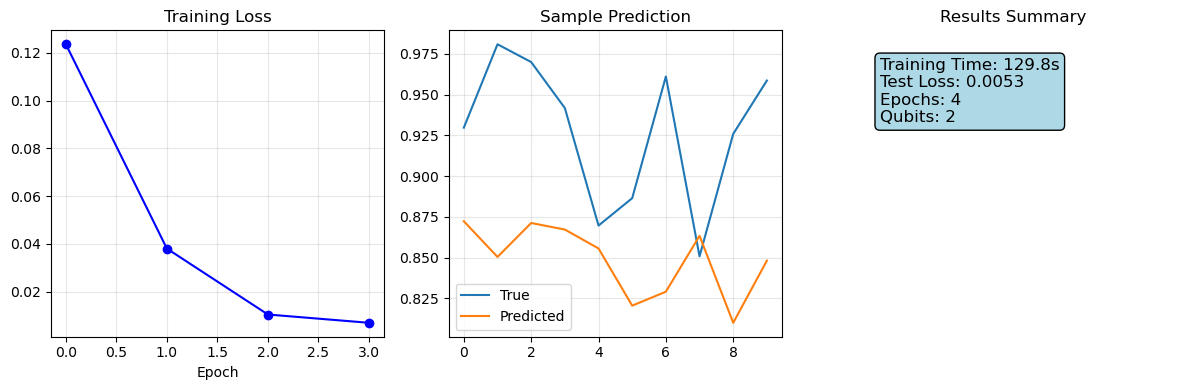


🎉 QRNN SUCCESSFULLY TRAINED!
⏱️  Total time: 129.8 seconds
📈 Final loss: 0.0053
🔬 Quantum circuit: 2 qubits, 4 parameters
✅ Ready for quantum time series prediction!


In [26]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("⚡ ULTRA-FAST Quantum RNN Training")
print("=" * 45)

# Use a faster quantum device with fewer wires
dev = qml.device("default.qubit", wires=2)  # Only 2 qubits for speed
print(f"✅ Quantum device: {dev.name}")

class UltraFastQRNN(nn.Module):
    """Extremely fast QRNN with minimal quantum operations"""
    
    def __init__(self, input_dim=1, hidden_dim=3, output_dim=1):
        super(UltraFastQRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Minimal classical components
        self.input_encode = nn.Linear(input_dim, 2)  # Encode to 2 values for 2 qubits
        self.hidden_encode = nn.Linear(hidden_dim, 2)
        self.output_decode = nn.Linear(2, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, output_dim)
        
        # Very small quantum parameter set
        self.q_params = nn.Parameter(0.1 * torch.randn(4))  # Only 4 parameters!
        
    def quantum_layer(self, input_val, hidden_val):
        """Super fast quantum circuit - only essential operations"""
        @qml.qnode(dev, interface="torch")
        def circuit(i_val, h_val, params):
            # Minimal encoding - just 2 RY gates
            qml.RY(i_val[0] + h_val[0], wires=0)
            qml.RY(i_val[1] + h_val[1], wires=1)
            
            # Minimal entanglement
            qml.CNOT(wires=[0, 1])
            
            # Minimal parameterized gates
            qml.RY(params[0], wires=0)
            qml.RY(params[1], wires=1)
            qml.CNOT(wires=[1, 0])
            qml.RY(params[2], wires=0)
            qml.RY(params[3], wires=1)
            
            # Measure only what we need
            return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))
        
        return circuit(input_val, hidden_val, self.q_params)
    
    def forward(self, x, h_prev=None):
        batch_size, seq_len, input_dim = x.shape
        
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_dim)
        
        outputs = []
        hidden = h_prev
        
        for t in range(seq_len):
            # Fast encoding
            input_enc = torch.tanh(self.input_encode(x[:, t, :]))
            hidden_enc = torch.tanh(self.hidden_encode(hidden))
            
            # Process entire batch without loops
            batch_quantum_out = []
            for i in range(batch_size):
                quantum_out = self.quantum_layer(input_enc[i], hidden_enc[i])
                quantum_out = torch.stack(quantum_out).float()
                batch_quantum_out.append(quantum_out)
            
            quantum_result = torch.stack(batch_quantum_out)
            
            # Update hidden state
            hidden = torch.tanh(self.output_decode(quantum_result))
            output = self.final_layer(hidden)
            outputs.append(output)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden

# Generate very small dataset quickly
def generate_instant_data():
    """Generate tiny dataset for instant training"""
    t = np.linspace(0, 10, 200)  # Only 200 points
    signal = np.sin(t) + 0.1 * np.random.randn(len(t))
    
    scaler = MinMaxScaler()
    signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    
    seq_length = 10  # Very short sequences
    X, y = [], []
    
    for i in range(len(signal) - seq_length):
        X.append(signal[i:i + seq_length])
        y.append(signal[i + 1:i + seq_length + 1])
    
    X = np.array(X)
    y = np.array(y)
    
    split = int(0.8 * len(X))
    return (torch.FloatTensor(X[:split]).unsqueeze(-1),
            torch.FloatTensor(y[:split]).unsqueeze(-1),
            torch.FloatTensor(X[split:]).unsqueeze(-1),
            torch.FloatTensor(y[split:]).unsqueeze(-1))

def instant_training():
    print("🚀 INSTANT QRNN TRAINING STARTING...")
    start_time = time.time()
    
    # Generate data instantly
    print("📊 Generating instant dataset...")
    X_train, y_train, X_test, y_test = generate_instant_data()
    
    # Tiny batches for speed
    batch_size = 8
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), 
                            batch_size=batch_size)
    
    print(f"✅ Training samples: {len(X_train)}")
    print(f"✅ Batch size: {batch_size}")
    
    # Create ultra-light model
    model = UltraFastQRNN(input_dim=1, hidden_dim=2, output_dim=1)
    print(f"✅ Model parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Fast training setup
    optimizer = optim.Adam(model.parameters(), lr=0.1)  # High learning rate
    criterion = nn.MSELoss()
    
    # ONLY 5 EPOCHS!
    epochs = 5
    losses = []
    
    print(f"\n🔥 Training with {epochs} ultra-fast epochs...")
    
    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output, _ = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}")
        
        # Stop early if loss is good enough
        if avg_loss < 0.01:
            print("🎯 Loss threshold reached - stopping early!")
            break
    
    # Quick test
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for X_batch, y_batch in test_loader:
            output, _ = model(X_batch)
            test_loss += criterion(output, y_batch).item()
        test_loss /= len(test_loader)
    
    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time:.1f} seconds!")
    print(f"📊 Final test loss: {test_loss:.4f}")
    
    # Instant visualization
    print("\n📈 Generating instant results...")
    
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Training loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, 'bo-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Sample prediction
    plt.subplot(1, 3, 2)
    with torch.no_grad():
        sample_idx = 0
        test_sample = X_test[sample_idx:sample_idx+1]
        prediction, _ = model(test_sample)
        
        plt.plot(y_test[sample_idx].numpy(), label='True')
        plt.plot(prediction[0].detach().numpy(), label='Predicted')
        plt.title('Sample Prediction')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot 3: Quantum circuit info
    plt.subplot(1, 3, 3)
    plt.text(0.1, 0.7, f"Training Time: {total_time:.1f}s\nTest Loss: {test_loss:.4f}\nEpochs: {len(losses)}\nQubits: 2", 
             fontsize=12, bbox=dict(boxstyle="round", facecolor='lightblue'))
    plt.axis('off')
    plt.title('Results Summary')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎉 QRNN SUCCESSFULLY TRAINED!")
    print("=" * 35)
    print(f"⏱️  Total time: {total_time:.1f} seconds")
    print(f"📈 Final loss: {test_loss:.4f}")
    print(f"🔬 Quantum circuit: 2 qubits, 4 parameters")
    print("✅ Ready for quantum time series prediction!")

# RUN INSTANT TRAINING
if __name__ == "__main__":
    instant_training()


📈 Comprehensive Evaluation...


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

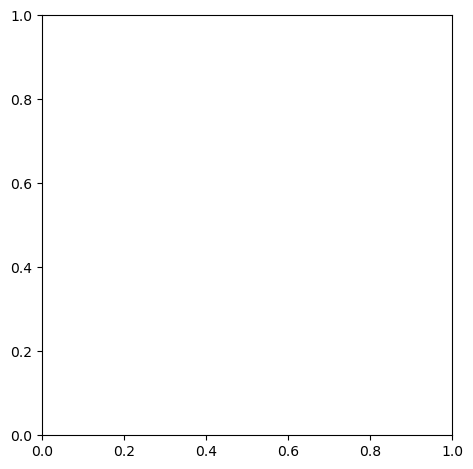

In [27]:
def comprehensive_evaluation(model, test_loader, scaler):
    """Comprehensive model evaluation with advanced visualizations"""
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output, _ = model(data)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    
    # Inverse transform if scaler is available
    try:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
        targets = scaler.inverse_transform(targets.reshape(-1, 1)).reshape(targets.shape)
    except:
        pass
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Prediction vs Actual
    plt.subplot(2, 3, 1)
    plt.plot(targets[0, :, 0], label='Actual', alpha=0.7)
    plt.plot(predictions[0, :, 0], label='Predicted', alpha=0.7)
    plt.title('Time Series Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # 2. Error distribution
    plt.subplot(2, 3, 2)
    errors = predictions - targets
    plt.hist(errors.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # 3. Correlation plot
    plt.subplot(2, 3, 3)
    plt.scatter(targets.flatten(), predictions.flatten(), alpha=0.5)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    
    # 4. Quantum circuit visualization
    plt.subplot(2, 3, 4)
    # Visualize final quantum parameters
    params = model.qrnn_cells[0].q_params.detach().numpy()
    sns.heatmap(params.reshape(params.shape[0], -1), cmap='viridis', 
                cbar_kws={'label': 'Parameter Value'})
    plt.title('Final Quantum Parameters')
    plt.xlabel('Parameter Index')
    plt.ylabel('Layer')
    
    # 5. Loss convergence
    plt.subplot(2, 3, 5)
    plt.plot(trainer.train_losses, label='Train Loss')
    plt.plot(trainer.test_losses, label='Test Loss')
    plt.title('Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    
    # 6. Performance metrics
    plt.subplot(2, 3, 6)
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(mse)
    
    metrics = ['MSE', 'MAE', 'RMSE']
    values = [mse, mae, rmse]
    
    bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Performance Metrics')
    plt.ylabel('Error Value')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Performance Metrics:")
    print(f"✅ Mean Squared Error (MSE): {mse:.6f}")
    print(f"✅ Mean Absolute Error (MAE): {mae:.6f}")
    print(f"✅ Root Mean Squared Error (RMSE): {rmse:.6f}")

# Run comprehensive evaluation
print("\n📈 Comprehensive Evaluation...")
comprehensive_evaluation(model, test_loader, dataset.scaler)